In [ ]:
import os
import uproot
import numpy as np

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for branch in branches:
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

def load_root_files(file_path1, file_path2, branches=None, print_branches=False):
    all_branches = {}
    def load_file(file_path, all_branches):
        with uproot.open(file_path) as file:
                tree = file["tree"]
                # Load all ROOT branches into array if not specified
                if branches is None:
                    file_branches = tree.keys()
                else:
                    file_branches = branches
                # Option to print the branch names
                if print_branches:
                    print(f"Branches in {file_path}:", tree.keys())
                # Each branch is added to the dictionary
                for branch in file_branches:
                    try:
                        if branch in all_branches:
                            all_branches[branch] = np.concatenate(
                                (all_branches[branch], tree[branch].array(library="np"))
                            )
                        else:
                            all_branches[branch] = tree[branch].array(library="np")
                    except uproot.KeyInFileError as e:
                        print(f"KeyInFileError in {file_path}: {e}")
                # Number of events in file
                all_branches['event'] = all_branches.get('event', 0) + tree.num_entries
    load_file(file_path1, all_branches)
    load_file(file_path2, all_branches)

    return all_branches

branches_list = [
    't4_innerRadius',
    't4_outerRadius',
    't4_pt',
    't4_eta',
    't4_phi',
    't4_isFake',
    't4_t3_idx0',
    't4_t3_idx1',
    't4_pMatched',
    't4_sim_vxy',
    't4_sim_vz'
]

# Hit-dependent branches
suffixes = ['r', 'z', 'eta', 'phi', 'layer']
branches_list += [f't4_t3_{i}_{suffix}' for i in [0, 2, 4] for suffix in suffixes]

# file_path = "../../T4allT3chargecut_T5allcut_dynam_occ_new.root"
# branches = load_root_file(file_path, branches_list)
PU_file_path = "PU_500events.root"
cube_file_path = "cube5_10000_addVertexInfo.root"
branches = load_root_files(PU_file_path, cube_file_path, branches_list)

In [2]:
z_max = np.max([np.max(event) for event in branches[f't4_t3_4_z'] if event.size>0])
r_max = np.max([np.max(event) for event in branches[f't4_t3_4_r'] if event.size>0])
eta_max = 2.5
phi_max = np.pi

print(f'Z max: {z_max}, R max: {r_max}, Eta max: {eta_max}')

def delta_phi(phi1, phi2):
    delta = phi1 - phi2
    # Adjust delta to be within the range [-pi, pi]
    if delta > np.pi:
        delta -= 2 * np.pi
    elif delta < -np.pi:
        delta += 2 * np.pi
    return delta

Z max: 267.2349853515625, R max: 110.10993957519531, Eta max: 2.5


In [3]:
features_list = []
eta_list = [] # Used for DNN cut values

for event in range(branches['event']):
    # Determine the number of elements in this event
    num_elements = len(branches['t4_t3_idx0'][event])

    for i in range(num_elements):
        features_iter = []
        eta_iter = []
        
        idx0 = branches['t4_t3_idx0'][event][i]
        idx1 = branches['t4_t3_idx1'][event][i]

        eta1 = np.abs(branches['t4_t3_0_eta'][event][idx0])
        eta2 = np.abs(branches['t4_t3_2_eta'][event][idx0])
        eta3 = np.abs(branches['t4_t3_4_eta'][event][idx0])
        eta4 = np.abs(branches['t4_t3_4_eta'][event][idx1])

        phi1 = (branches['t4_t3_0_phi'][event][idx0])
        phi2 = (branches['t4_t3_2_phi'][event][idx0])
        phi3 = (branches['t4_t3_4_phi'][event][idx0])
        phi4 = (branches['t4_t3_4_phi'][event][idx1])

        z1 = np.abs(branches['t4_t3_0_z'][event][idx0])
        z2 = np.abs(branches['t4_t3_2_z'][event][idx0])
        z3 = np.abs(branches['t4_t3_4_z'][event][idx0])
        z4 = np.abs(branches['t4_t3_4_z'][event][idx1])

        r1 = branches['t4_t3_0_r'][event][idx0]
        r2 = branches['t4_t3_2_r'][event][idx0]
        r3 = branches['t4_t3_4_r'][event][idx0]
        r4 = branches['t4_t3_4_r'][event][idx1]

        innerRad = branches['t4_innerRadius'][event][i]
        outerRad = branches['t4_outerRadius'][event][i]


        # Construct the input feature vector using pairwise differences
        features_iter = [
            eta1 / eta_max,                      # First hit eta, normalized
            np.abs(phi1) / phi_max,              # First hit phi, normalized
            z1 / z_max,                          # First hit z, normalized
            r1 / r_max,                          # First hit r, normalized

            eta2 - eta1,                         # Difference in eta between hit 2 and 1
            delta_phi(phi2, phi1) / phi_max,     # Difference in phi between hit 2 and 1
            (z2 - z1) / z_max,                   # Difference in z between hit 2 and 1, normalized
            (r2 - r1) / r_max,                   # Difference in r between hit 2 and 1, normalized

            eta3 - eta2,                         # Difference in eta between hit 3 and 2
            delta_phi(phi3, phi2) / phi_max,     # Difference in phi between hit 3 and 2
            (z3 - z2) / z_max,                   # Difference in z between hit 3 and 2, normalized
            (r3 - r2) / r_max,                   # Difference in r between hit 3 and 2, normalized

            eta4 - eta3,                         # Difference in eta between hit 4 and 3
            delta_phi(phi4, phi3) / phi_max,     # Difference in phi between hit 4 and 3
            (z4 - z3) / z_max,                   # Difference in z between hit 4 and 3, normalized
            (r4 - r3) / r_max,                   # Difference in r between hit 4 and 3, normalized

            np.log10(innerRad),
            np.log10(outerRad),
            np.log10(innerRad/outerRad),
            # rzChiSquared
            # innerRad,
            # outerRad,
            # innerRad/outerRad,
        ]

        # Use the abs eta value of first hit to select cut thresholds
        eta_iter.extend([np.abs(branches['t4_t3_0_eta'][event][idx0])])
        
        # Append the feature vector to the list
        features_list.append(features_iter)
        eta_list.append(eta_iter)

# Convert the list of features to a NumPy array
features = np.array(features_list).T
eta_list = np.array(eta_list).T

In [6]:
import torch

# Stack features along a new axis to form a single array suitable for NN input
input_features_numpy = np.stack(features, axis=-1)

# Identify rows with NaN or Inf values
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)

# Apply mask across all columns: retain a row only if all its entries are neither NaN nor Inf
filtered_input_features_numpy = input_features_numpy[np.all(mask, axis=1)]
# t4_isFake_filtered = np.concatenate(branches['t4_isFake'])[np.all(mask, axis=1)]
t4_isFake_filtered = (np.concatenate(branches['t4_pMatched']) <= 0.75)[np.all(mask, axis=1)]
t4_sim_vxy_filtered = np.concatenate(branches['t4_sim_vxy'])[np.all(mask, axis=1)]

# Convert to PyTorch tensor when ready to use with NN
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)

In [7]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def create_multiclass_labels(t4_isFake, t4_sim_vxy, displacement_threshold=0.1):
    num_samples = len(t4_isFake)
    labels = torch.zeros((num_samples, 3))
    
    # Fake tracks (class 0)
    fake_mask = t4_isFake
    labels[fake_mask, 0] = 1
    
    # Real tracks
    real_mask = ~fake_mask
    
    # Split real tracks into prompt (class 1) and displaced (class 2)
    prompt_mask = (t4_sim_vxy <= displacement_threshold) & real_mask
    displaced_mask = (t4_sim_vxy > displacement_threshold) & real_mask
    
    labels[prompt_mask, 1] = 1
    labels[displaced_mask, 2] = 1
    
    return labels

# labels_tensor = 1 - torch.tensor(t4_isFake_filtered, dtype=torch.float32)
labels_tensor = create_multiclass_labels(
    t4_isFake_filtered,
    t4_sim_vxy_filtered
)

# Neural network for multi-class classification
class MultiClassNeuralNetwork(nn.Module):
    def __init__(self):
        super(MultiClassNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 3)
        
    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        return nn.functional.softmax(x, dim=1)

nan_mask = torch.isnan(input_features_tensor).any(dim=1)

# class MyNeuralNetwork(nn.Module):
#     def __init__(self):
#         super(MyNeuralNetwork, self).__init__()
#         self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
#         self.layer2 = nn.Linear(32, 32)
#         self.output_layer = nn.Linear(32, 3)

#     def forward(self, x):
#         x = self.layer1(x)
#         x = nn.ReLU()(x)
#         x = self.layer2(x)
#         x = nn.ReLU()(x)
#         x = self.output_layer(x)
#         x = torch.sigmoid(x)
#         return x

# nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor)

Using device: cuda


In [6]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create labels tensor
def create_multiclass_labels(t4_isFake, t4_sim_vxy, displacement_threshold=0.1):
    num_samples = len(t4_isFake)
    labels = torch.zeros((num_samples, 3))
    
    # Fake tracks (class 0)
    fake_mask = t4_isFake
    labels[fake_mask, 0] = 1
    
    # Real tracks
    real_mask = ~fake_mask
    # real_mask = 1-t4_isFake
    
    # Split real tracks into prompt (class 1) and displaced (class 2)
    prompt_mask = (t4_sim_vxy <= displacement_threshold) & real_mask
    displaced_mask = (t4_sim_vxy > displacement_threshold) & real_mask
    
    labels[prompt_mask, 1] = 1
    labels[displaced_mask, 2] = 1

    print(f"Total samples: {num_samples}")
    print(f"Fake count: {fake_mask.sum().item()}")
    print(f"Real count: {real_mask.sum().item()}")
    print(f"Prompt count: {prompt_mask.sum().item()}")
    print(f"Displaced count: {displaced_mask.sum().item()}")
    
    return labels

# labels_tensor = 1 - torch.tensor(t4_isFake_filtered, dtype=torch.float32)
labels_tensor = create_multiclass_labels(
    t4_isFake_filtered,
    t4_sim_vxy_filtered
)

# Set initial downsample fraction
# initial_downsample_fraction = 1.0  # Adjust this value as needed


# class MyNeuralNetwork(nn.Module):
#     def __init__(self):
#         super(MyNeuralNetwork, self).__init__()
#         self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
#         self.layer2 = nn.Linear(32, 32)
#         self.output_layer = nn.Linear(32, 1)

#     def forward(self, x):
#         x = self.layer1(x)
#         x = nn.ReLU()(x)
#         x = self.layer2(x)
#         x = nn.ReLU()(x)
#         x = self.output_layer(x)
#         x = torch.sigmoid(x)
#         return x
    
# class WeightedBCELoss(nn.Module):
#     def __init__(self):
#         super(WeightedBCELoss, self).__init__()
        
#     def forward(self, outputs, targets, weights):
#         eps = 1e-7
#         losses = -(weights * (targets * torch.log(outputs + eps) + 
#                             (1 - targets) * torch.log(1 - outputs + eps)))
#         return losses.mean()

# Neural network for multi-class classification
class MultiClassNeuralNetwork(nn.Module):
    def __init__(self):
        super(MultiClassNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 3)
        
    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        return nn.functional.softmax(x, dim=1)

# Weighted loss function for multi-class
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(WeightedCrossEntropyLoss, self).__init__()
        
    def forward(self, outputs, targets, weights):
        eps = 1e-7
        log_probs = torch.log(outputs + eps)
        losses = -weights * torch.sum(targets * log_probs, dim=1)
        return losses.mean()

# def calculate_sample_weights(t4_pt, t4_sim_vxy, weight_factor=6.0):
#     """
#     Calculate sample weights giving higher importance to displaced t5's
    
#     Args:
#         t4_sim_vxy: Array of t4 simulation values
#         weight_factor: How much more weight to give to displaced samples
    
#     Returns:
#         Tensor of sample weights
#     """
    
#     weights = torch.ones(len(t4_pt[np.all(mask, axis=1)]))
#     print(weights.shape)
#     highPt_mask = t4_pt[np.all(mask, axis=1)] > 5 
#     displaced_mask = t4_sim_vxy[np.all(mask, axis=1)] > 0.1
#     weights[displaced_mask] = weight_factor
#     weights[highPt_mask] = weight_factor
#     return weights

# Calculate class weights (each sample gets a weight to equalize class contributions)
def calculate_class_weights(labels):
    class_counts = torch.sum(labels, dim=0)
    total_samples = len(labels)
    class_weights = total_samples / (3 * class_counts)  # Normalize across 3 classes
    
    sample_weights = torch.zeros(len(labels))
    for i in range(3):
        sample_weights[labels[:, i] == 1] = class_weights[i]
    
    return sample_weights

# Print initial dataset size
print(f"Initial dataset size: {len(labels_tensor)}")

# Calculate sample weights
# sample_weights = calculate_sample_weights(torch.tensor(np.concatenate(branches['t4_pt'])), torch.tensor(np.concatenate(branches['t4_sim_vxy'])))
sample_weights = calculate_class_weights(labels_tensor)

# Remove rows with NaN and update weights accordingly
# nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor)
nan_mask = torch.isnan(input_features_tensor).any(dim=1)
filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]
# print(filtered_labels.shape)
# Print class distribution before downsampling
class_counts_before = torch.sum(filtered_labels, dim=0)
print(f"Class distribution before downsampling - Fake: {class_counts_before[0]}, Prompt: {class_counts_before[1]}, Displaced: {class_counts_before[2]}")

# Option to downsample each class (multi-class)
downsample_classes = True  # Set to False to disable downsampling
if downsample_classes:
    # Define downsampling ratios for each class:
    # For example, downsample fakes (class 0) to 50% and keep prompt (class 1) and displaced (class 2) at 100%
    downsample_ratios = {0: 0.5, 1: 1.0, 2: 1.0}
    indices_list = []
    for cls in range(3):
        # Find indices for the current class
        cls_mask = (filtered_labels[:, cls] == 1)
        cls_indices = torch.nonzero(cls_mask).squeeze()
        ratio = downsample_ratios.get(cls, 1.0)
        num_cls = cls_indices.numel()
        num_to_sample = int(num_cls * ratio)
        # Ensure at least one sample is kept if available
        if num_to_sample < 1 and num_cls > 0:
            num_to_sample = 1
        # Shuffle and select the desired number of samples
        cls_indices_shuffled = cls_indices[torch.randperm(num_cls)]
        sampled_cls_indices = cls_indices_shuffled[:num_to_sample]
        indices_list.append(sampled_cls_indices)
    
    # Combine the indices from all classes
    selected_indices = torch.cat(indices_list)
    filtered_inputs = filtered_inputs[selected_indices]
    filtered_labels = filtered_labels[selected_indices]

# Print class distribution after downsampling
class_counts_after = torch.sum(filtered_labels, dim=0)
print(f"Class distribution after downsampling - Fake: {class_counts_after[0]}, Prompt: {class_counts_after[1]}, Displaced: {class_counts_after[2]}")

# Recalculate sample weights after downsampling (equal weighting per class based on new counts)
sample_weights = calculate_class_weights(filtered_labels)
filtered_weights = sample_weights    

# # Initial downsampling of entire dataset
# if initial_downsample_fraction < 1.0:
#     total_samples = len(filtered_labels)
#     samples_to_keep = int(total_samples * initial_downsample_fraction)
#     indices = torch.randperm(total_samples)[:samples_to_keep]
#     filtered_inputs = filtered_inputs[indices]
#     filtered_labels = filtered_labels[indices]
#     filtered_weights = filtered_weights[indices]

# print(f"Dataset size after initial {initial_downsample_fraction*100}% downsampling: {len(filtered_labels)}")

# # Count samples in each class after initial downsampling
# class_counts = torch.bincount(filtered_labels.int())
# print(f"Class distribution after initial downsampling - Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

# # Balance classes while maintaining weights
# minority_class = 0 if class_counts[0] < class_counts[1] else 1
# minority_indices = (filtered_labels == minority_class).nonzero(as_tuple=True)[0]
# majority_indices = (filtered_labels == (1 - minority_class)).nonzero(as_tuple=True)[0]
# downsampled_majority_indices = majority_indices[torch.randperm(len(majority_indices))[:len(minority_indices)]] #adjust downsample ratio

# balanced_indices = torch.cat((minority_indices, downsampled_majority_indices))

# # Create balanced dataset with weights
# balanced_inputs = filtered_inputs[balanced_indices]
# balanced_labels = filtered_labels[balanced_indices]
# balanced_weights = filtered_weights[balanced_indices]

# # Verify balanced distribution
# balanced_counts = torch.bincount(balanced_labels.int())
# print(f"Final class distribution after balancing - Class 0: {balanced_counts[0]}, Class 1: {balanced_counts[1]}")

# Create dataset with weights
dataset = TensorDataset(filtered_inputs, filtered_labels, filtered_weights) #multi-class
# dataset = TensorDataset(balanced_inputs, balanced_labels, balanced_weights) 
# dataset = TensorDataset(balanced_inputs, balanced_labels) #no weighting
# dataset = TensorDataset(filtered_inputs, filtered_labels) #no down sample

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=10, pin_memory=True)

# Initialize model and optimizer
# model = MyNeuralNetwork().to(device)
model = MultiClassNeuralNetwork().to(device)
loss_function = WeightedCrossEntropyLoss() #multi-class
# loss_function = WeightedBCELoss() #use when add weights
# loss_function = nn.BCELoss() #unweighted
optimizer = Adam(model.parameters(), lr=0.0025)

# def evaluate_model(loader):
#     model.eval()
#     total = 0
#     correct = 0
#     with torch.no_grad():
#         for inputs, targets, weights in loader:
#         # for inputs, targets in loader:
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = model(inputs)
#             predicted = outputs.squeeze() > 0.5
#             total += targets.size(0)
#             correct += (predicted == targets.bool()).sum().item()
#     model.train()
#     return 100 * correct / total

def evaluate_loss(loader): #multi-class
    model.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for inputs, targets, weights in loader:
            inputs, targets, weights = inputs.to(device), targets.to(device), weights.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets, weights)
            total_loss += loss.item()
            num_batches += 1
    return total_loss / num_batches

# Training loop
num_epochs = 200
# loss_log = []
train_loss_log = []
test_loss_log = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    num_batches = 0

    for inputs, targets, weights in train_loader:
    # for inputs, targets in train_loader:
        inputs, targets, weights = inputs.to(device), targets.to(device), weights.to(device)
        # inputs, targets = inputs.to(device), targets.to(device)

    
        # Forward pass
        outputs = model(inputs)
        # loss = loss_function(outputs.squeeze(), targets, weights)
        loss = loss_function(outputs, targets, weights)
        epoch_loss += loss.item()
        num_batches += 1
        # loss = loss_function(outputs.squeeze(), targets)
        
        # loss_log.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average losses
    train_loss = epoch_loss / num_batches
    test_loss = evaluate_loss(test_loader)
    
    train_loss_log.append(train_loss)
    test_loss_log.append(test_loss)

    # test_accuracy = evaluate_model(test_loader)
    # train_accuracy = evaluate_model(train_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Acc: {test_accuracy:.2f}%')

Using device: cuda
Total samples: 13903885
Fake count: 9927054
Real count: 3976831
Prompt count: 3242301
Displaced count: 734530
Initial dataset size: 13903885
Class distribution before downsampling - Fake: 9927054.0, Prompt: 3242301.0, Displaced: 734530.0
Class distribution after downsampling - Fake: 4963527.0, Prompt: 3242301.0, Displaced: 734530.0
Epoch [1/200], Train Loss: 0.7039, Test Loss: 0.6660
Epoch [2/200], Train Loss: 0.6576, Test Loss: 0.6501
Epoch [3/200], Train Loss: 0.6452, Test Loss: 0.6375
Epoch [4/200], Train Loss: 0.6379, Test Loss: 0.6329
Epoch [5/200], Train Loss: 0.6311, Test Loss: 0.6235
Epoch [6/200], Train Loss: 0.6240, Test Loss: 0.6188
Epoch [7/200], Train Loss: 0.6200, Test Loss: 0.6167
Epoch [8/200], Train Loss: 0.6177, Test Loss: 0.6172
Epoch [9/200], Train Loss: 0.6162, Test Loss: 0.6108
Epoch [10/200], Train Loss: 0.6136, Test Loss: 0.6075
Epoch [11/200], Train Loss: 0.5996, Test Loss: 0.5799
Epoch [12/200], Train Loss: 0.5714, Test Loss: 0.5624
Epoch [1

In [7]:
# torch.save(model.state_dict(), "model.pth")
torch.save(model.state_dict(), "model_addDS.pth")

In [ ]:
#original

# from sklearn.metrics import accuracy_score

# # Convert tensors to numpy for simplicity in permutation
# input_features_np = input_features_tensor.numpy()
# labels_np = labels_tensor.numpy()

# def model_accuracy(features, labels, model):
#     model.eval()  # Set the model to evaluation mode
#     inputs = features.to(device)
#     labels = labels.to(device)
#     with torch.no_grad():
#         outputs = model(inputs)
#         predicted = (outputs.squeeze() > 0.5).float()  # Update threshold as necessary
#         accuracy = (predicted == labels).float().mean().item()
#     return accuracy

# # Use the original input_features_tensor and labels_tensor directly
# baseline_accuracy = model_accuracy(input_features_tensor, labels_tensor, model)
# print(f"Baseline accuracy: {baseline_accuracy}")

# # Initialize an array to store feature importances
# feature_importances = np.zeros(input_features_tensor.shape[1])

# # Permute each feature and calculate the drop in accuracy
# for i in range(input_features_tensor.shape[1]):
#     permuted_features = input_features_tensor.clone()
#     permuted_features[:, i] = permuted_features[torch.randperm(permuted_features.size(0)), i]  # Permute feature

#     permuted_accuracy = model_accuracy(permuted_features, labels_tensor, model)
#     feature_importances[i] = baseline_accuracy - permuted_accuracy

# # Ranking features by importance
# important_features_indices = np.argsort(feature_importances)[::-1]  # Indices of features in descending importance
# important_features_scores = np.sort(feature_importances)[::-1]  # Importance scores in descending order

# print("Feature importances:")
# for idx, score in zip(important_features_indices, important_features_scores):
#     print(f"Feature {idx} importance: {score:.4f}")

Baseline accuracy: 0.9062655568122864
Feature importances:
Feature 18 importance: 0.1899
Feature 12 importance: 0.0591
Feature 8 importance: 0.0370
Feature 4 importance: 0.0361
Feature 0 importance: 0.0346
Feature 2 importance: 0.0244
Feature 16 importance: 0.0137
Feature 5 importance: 0.0113
Feature 17 importance: 0.0095
Feature 6 importance: 0.0081
Feature 11 importance: 0.0049
Feature 3 importance: 0.0044
Feature 15 importance: 0.0038
Feature 10 importance: 0.0029
Feature 14 importance: 0.0007
Feature 1 importance: -0.0000
Feature 7 importance: -0.0001
Feature 13 importance: -0.0006
Feature 19 importance: -0.0007
Feature 9 importance: -0.0008


In [8]:
#multi-class
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# Convert tensors to numpy for simplicity if you want to manipulate them outside of PyTorch
input_features_np = input_features_tensor.numpy()
labels_np = torch.argmax(labels_tensor, dim=1).numpy()  # Convert one-hot to class indices

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def model_accuracy(features, labels, model):
    """
    Compute accuracy for a multi-class classification model
    that outputs probabilities of size [batch_size, num_classes].
    """
    model.eval()  # Set the model to evaluation mode
    
    # Move the features and labels to the correct device
    inputs = features.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(inputs)  # shape: [batch_size, num_classes]
        # For multi-class, the predicted class is argmax of the probabilities
        predicted = torch.argmax(outputs, dim=1)
        # Convert one-hot encoded labels to class indices if needed
        if len(labels.shape) > 1:
            labels = torch.argmax(labels, dim=1)
        # Compute mean accuracy
        accuracy = (predicted == labels).float().mean().item()
    
    return accuracy

# Compute baseline accuracy
baseline_accuracy = model_accuracy(input_features_tensor, labels_tensor, model)
print(f"Baseline accuracy: {baseline_accuracy:.4f}")

# Initialize array to store feature importances
feature_importances = np.zeros(input_features_tensor.shape[1])

# Iterate over each feature for permutation importance
for i in range(input_features_tensor.shape[1]):
    # Create a copy of the original features
    permuted_features = input_features_tensor.clone()
    
    # Permute feature i across all examples
    # We do this by shuffling the rows for that specific column
    permuted_features[:, i] = permuted_features[torch.randperm(permuted_features.size(0)), i]
    
    # Compute accuracy after permutation
    permuted_accuracy = model_accuracy(permuted_features, labels_tensor, model)
    
    # The drop in accuracy is used as a measure of feature importance
    feature_importances[i] = baseline_accuracy - permuted_accuracy

# Sort features by descending importance
important_features_indices = np.argsort(feature_importances)[::-1]
important_features_scores = np.sort(feature_importances)[::-1]

# Print out results
print("\nFeature importances:")
for idx, score in zip(important_features_indices, important_features_scores):
    print(f"Feature {idx} importance: {score:.4f}")

Baseline accuracy: 0.8877

Feature importances:
Feature 18 importance: 0.1888
Feature 5 importance: 0.1654
Feature 9 importance: 0.1605
Feature 0 importance: 0.1537
Feature 16 importance: 0.1458
Feature 17 importance: 0.1446
Feature 7 importance: 0.1436
Feature 2 importance: 0.1130
Feature 11 importance: 0.0934
Feature 6 importance: 0.0879
Feature 12 importance: 0.0785
Feature 13 importance: 0.0680
Feature 10 importance: 0.0643
Feature 4 importance: 0.0613
Feature 8 importance: 0.0458
Feature 14 importance: 0.0388
Feature 15 importance: 0.0352
Feature 3 importance: 0.0327
Feature 1 importance: -0.0000


In [ ]:
#single class

# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# def model_outputs(features, model):
#     model.eval()  # Set the model to evaluation mode
#     with torch.no_grad():
#         inputs = torch.tensor(features, dtype=torch.float32).to(device)
#         outputs = model(inputs).squeeze().cpu().numpy()
#     return outputs

# # Calculate model outputs
# probabilities = model_outputs(filtered_inputs, model)

# # Calculate ROC curve and AUC
# fpr, tpr, thresholds = roc_curve(filtered_labels, probabilities)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure()
# lw = 2  # Line width
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic: PU200 175 events')
# plt.legend(loc="lower right")
# plt.show()

/tmp/ipykernel_683670/1073338706.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


ValueError: multilabel-indicator format is not supported

In [9]:
def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()

    # Print weights
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()

def print_model_weights_biases(model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Iterate through all named modules in the model
    for name, module in model.named_modules():
        # Check if the module is a linear layer
        if isinstance(module, nn.Linear):
            # Get weights and biases
            weights = module.weight.data.cpu().numpy()
            biases = module.bias.data.cpu().numpy()

            # Print formatted weights and biases
            print_formatted_weights_biases(weights, biases, name.replace('.', '_'))

print_model_weights_biases(model)


ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_layer1[32] = {
-0.1192672f, 4.6128407f, -2.5082555f, -0.0482164f, 5.1578393f, 0.1752233f, -0.6997983f, -0.0344732f, 0.0596772f, 0.1776919f, -0.0311515f, -0.2757702f, 2.3574224f, -1.4157041f, -3.5997803f, -0.1978408f, 1.8547847f, -1.3382285f, -0.9675246f, 0.1933428f, 4.2865996f, -0.2300702f, 0.8455911f, 1.0893626f, -0.0977272f, -1.3448272f, 1.3504575f, 2.6781168f, -0.2246585f, 2.1447430f, 0.0907345f, -0.1292634f };

ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_layer1[19][32] = {
{ -0.1224677f, -0.3516750f, 3.6735840f, -0.1231890f, 0.0373866f, -0.3761206f, 1.2682194f, 0.0161760f, -0.0481026f, 0.0450190f, -0.8536395f, -0.2047023f, -1.2634122f, 0.2427920f, -0.3168414f, 0.0524038f, 0.3807373f, 2.2943063f, -0.1368237f, -0.2230460f, -0.7025608f, -0.2328706f, 1.0237839f, 2.3014064f, 0.7786369f, 2.1072605f, 0.4948550f, 1.4390002f, -1.5553585f, -0.1086578f, -0.2046075f, 0.5985041f },
{ 0.0881005f, -0.0053233f, 0.0028024f, 0.0581611f, -0.0140803f, -0

In [8]:
model = MultiClassNeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", map_location=torch.device('cuda')))

/tmp/ipykernel_3139591/707330739.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth", map_location=torch.device('cuda')))


<All keys matched successfully>

In [9]:
# Ensure input_features_tensor is moved to the appropriate device
input_features_tensor = input_features_tensor.to(device)
# filtered_inputs = input_features_tensor[~nan_mask]
# filtered_labels = labels_tensor[~nan_mask]

# Make predictions
with torch.no_grad():
    model.eval()
    outputs = model(input_features_tensor)
    predictions = outputs.squeeze().cpu().numpy()

# full_tracks = (np.concatenate(branches['t4_isFake'])[np.all(mask, axis=1)] == 0) * (np.concatenate(branches['t4_pMatched'])[np.all(mask, axis=1)] > 0.95)
full_tracks = (np.concatenate(branches['t4_pMatched']) > 0.95)


In [8]:
def model_outputs(features, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        inputs = torch.tensor(features, dtype=torch.float32).to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
    return outputs

# Calculate model outputs
probabilities = model_outputs(filtered_inputs, model)

/tmp/ipykernel_3175973/3296547289.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


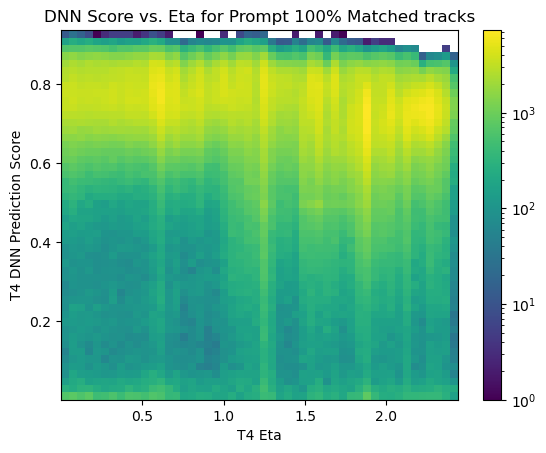

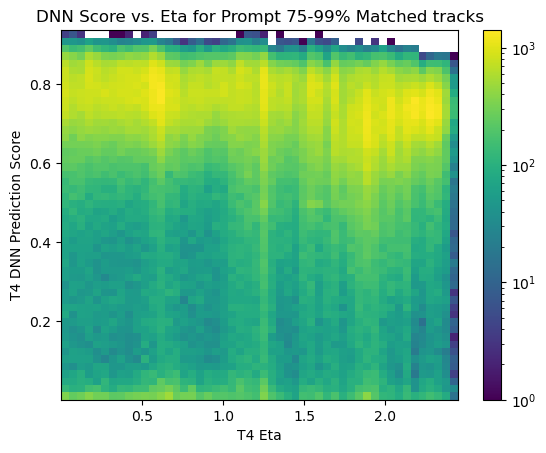

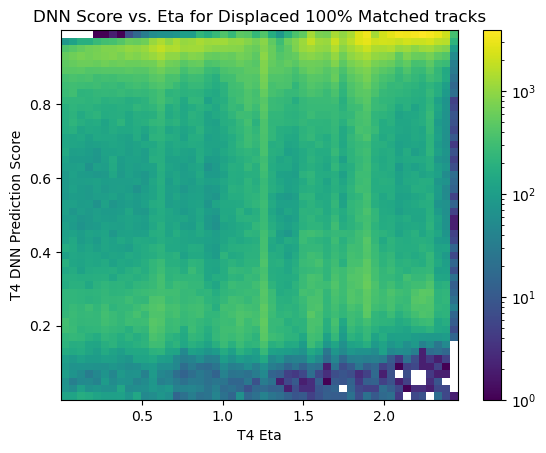

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
all_true = (np.concatenate(branches['t4_pMatched']) > 0.75)
not_perfect_true =(np.concatenate(branches['t4_pMatched']) > 0.75) & (np.concatenate(branches['t4_pMatched']) < 1) 
true_prompt_pred = predictions[:, 1]
true_displaced_pred = predictions[:,2]
true_prompt = ~(np.concatenate(branches['t4_sim_vxy']) > 0.1) & full_tracks
all_true_prompt = ~(np.concatenate(branches['t4_sim_vxy']) > 0.1) & all_true 
not_perfect_prompt = ~(np.concatenate(branches['t4_sim_vxy']) > 0.1) & not_perfect_true 
true_displaced = (np.concatenate(branches['t4_sim_vxy']) > 0.1) & full_tracks 
all_true_displaced =(np.concatenate(branches['t4_sim_vxy']) > 0.1) & all_true 
not_perfect_displaced = (np.concatenate(branches['t4_sim_vxy']) > 0.1) & not_perfect_true 

fake_pred = predictions[:,0]
fake_tracks = (np.concatenate(branches['t4_pMatched']) <= 0.75)
fake_prompt = ~(np.concatenate(branches['t4_sim_vxy']) > 0.1) & fake_tracks

fake_prompt_pred = 

plt.figure()

full_tracks =  (np.concatenate(branches['t4_pMatched']) > 0.95) 
plt.hist2d(eta_list[0][true_prompt], true_prompt_pred[true_prompt], bins=[50,50], norm=LogNorm())
plt.xlabel("T4 Eta")
plt.ylabel("T4 DNN Prediction Score")
plt.title("DNN Score vs. Eta for Prompt 100% Matched tracks")
plt.colorbar()
plt.show()

# plt.figure()
# plt.hist2d(eta_list[0][all_true_prompt], true_prompt_pred[all_true_prompt], bins=[50,50], norm=LogNorm())
# plt.xlabel("T4 Eta")
# plt.ylabel("T4 DNN Prediction Score")
# plt.title("DNN Score vs. Eta for Prompt >75% Matched tracks")
# # plt.colorbar()
# plt.show()

plt.figure()
plt.hist2d(eta_list[0][not_perfect_prompt], true_prompt_pred[not_perfect_prompt], bins=[50,50], norm=LogNorm())
plt.xlabel("T4 Eta")
plt.ylabel("T4 DNN Prediction Score")
plt.title("DNN Score vs. Eta for Prompt 75-99% Matched tracks")
plt.colorbar()
plt.show()

plt.figure()
plt.hist2d(eta_list[0][fake_prompt], true_prompt_pred[not_perfect_prompt], bins=[50,50], norm=LogNorm())
plt.xlabel("T4 Eta")
plt.ylabel("T4 DNN Prediction Score")
plt.title("DNN Score vs. Eta for Prompt 75-99% Matched tracks")
plt.colorbar()
plt.show()

plt.figure()
plt.hist2d(eta_list[0][true_displaced], true_displaced_pred[true_displaced], bins=[50,50], norm=LogNorm())
plt.xlabel("T4 Eta")
plt.ylabel("T4 DNN Prediction Score")
plt.title("DNN Score vs. Eta for Displaced 100% Matched tracks")
plt.colorbar()
plt.show()

# plt.figure()
# plt.hist2d(eta_list[0][all_true_displaced], true_displaced_pred[all_true_displaced], bins=[50,50], norm=LogNorm())
# plt.xlabel("T4 Eta")
# plt.ylabel("T4 DNN Prediction Score")
# plt.title("DNN Score vs. Eta for Displaced >75% Matched tracks")
# # plt.colorbar()
# plt.show()


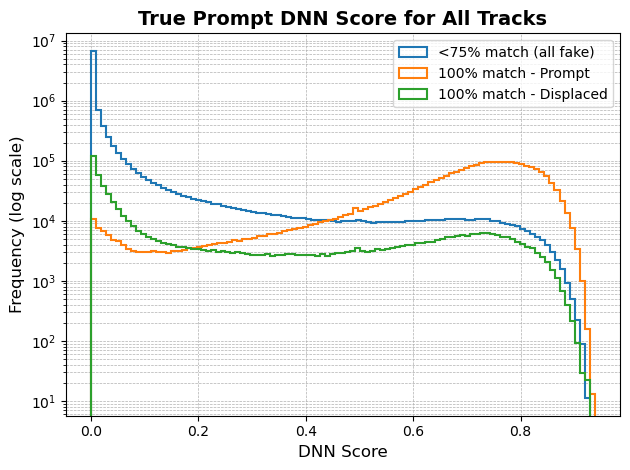

In [ ]:
fake_pred = predictions[:,0]
fake_tracks = (np.concatenate(branches['t4_pMatched']) <= 0.75)
plt.hist(true_prompt_pred[fake_tracks], bins=100, histtype='step', linewidth=1.5, label='<75% match (all fake)')  # Outline only, no fill
plt.hist(true_prompt_pred[true_prompt], bins=100, histtype='step', linewidth=1.5, label='100% match - Prompt')  # Outline only, no fill
plt.hist(true_prompt_pred[true_displaced], bins=100, histtype='step', linewidth=1.5, label='100% match - Displaced')  # Outline only, no fill

plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("True Prompt DNN Score for All Tracks", fontsize=14, weight='bold')
plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

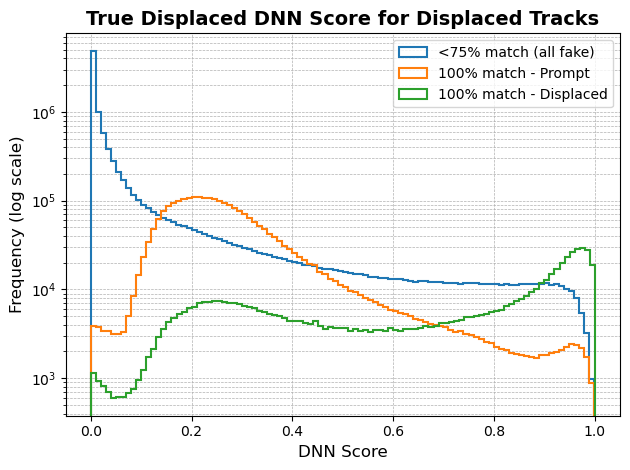

In [ ]:
plt.hist(true_displaced_pred[fake_tracks], bins=100, histtype='step', linewidth=1.5, label='<75% match (all fake)')  # Outline only, no fill
plt.hist(true_displaced_pred[true_prompt], bins=100, histtype='step', linewidth=1.5, label='100% match - Prompt')  # Outline only, no fill
plt.hist(true_displaced_pred[true_displaced], bins=100, histtype='step', linewidth=1.5, label='100% match - Displaced')  # Outline only, no fill

plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("True Displaced DNN Score for All Tracks", fontsize=14, weight='bold')
plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

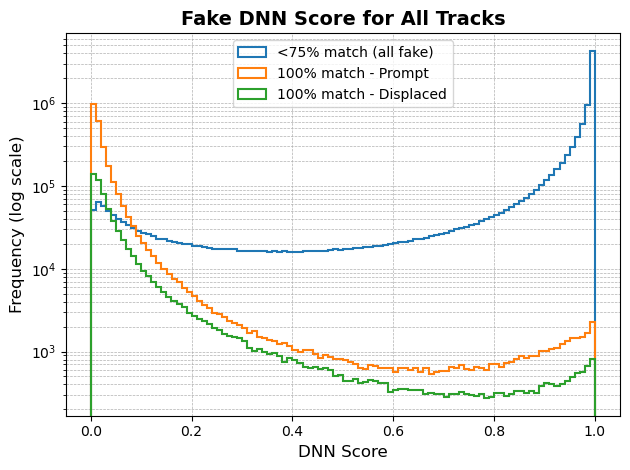

In [ ]:

plt.figure()
plt.hist(fake_pred[fake_tracks], bins=100, histtype='step', linewidth=1.5, label='<75% match (all fake)')  # Outline only, no fill
plt.hist(fake_pred[true_prompt], bins=100, histtype='step', linewidth=1.5, label='100% match - Prompt')  # Outline only, no fill
plt.hist(fake_pred[true_displaced], bins=100, histtype='step', linewidth=1.5, label='100% match - Displaced')  # Outline only, no fill


plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("Fake DNN Score for All Tracks", fontsize=14, weight='bold')
plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



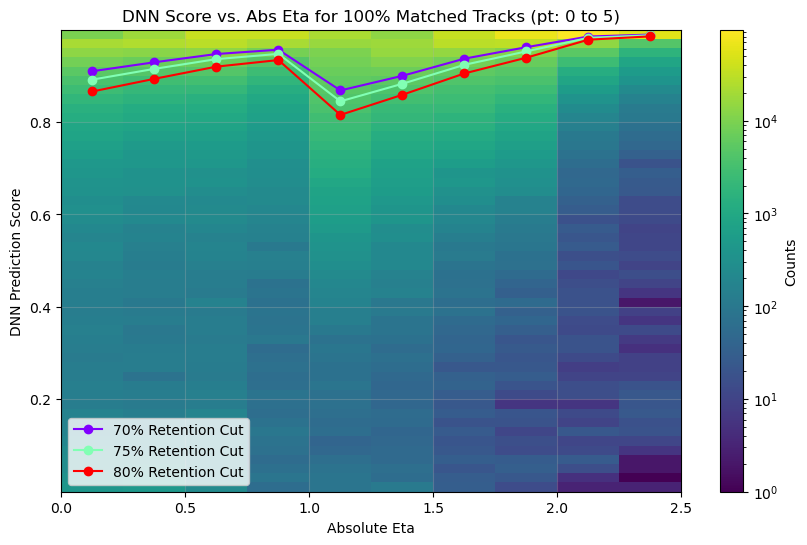


pt: 0 to 5
70% Retention Cut: {0.91, 0.9293, 0.9472, 0.9565, 0.8684, 0.9, 0.9372, 0.962, 0.9851, 0.9893} Mean: 0.9385
75% Retention Cut: {0.8918, 0.9151, 0.9362, 0.9475, 0.8448, 0.8828, 0.9238, 0.9529, 0.9823, 0.9878} Mean: 0.9265
80% Retention Cut: {0.8661, 0.8935, 0.9199, 0.9341, 0.8154, 0.859, 0.9052, 0.9393, 0.9783, 0.9854} Mean: 0.9096


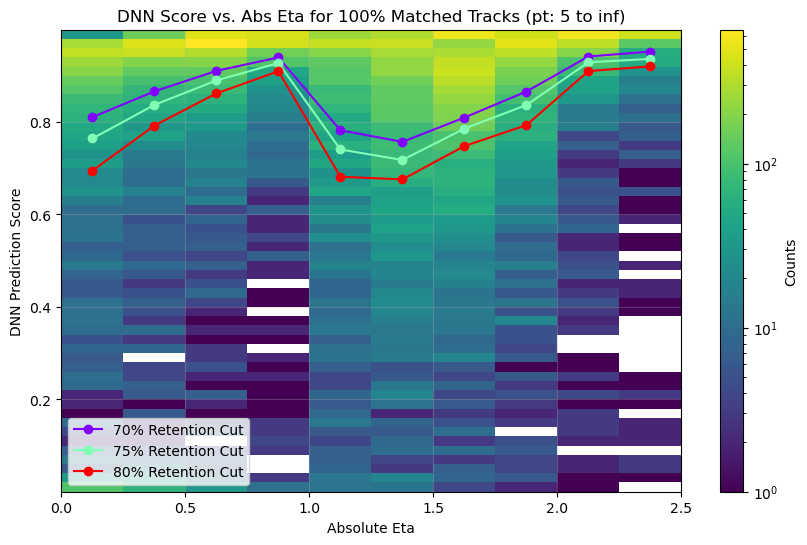


pt: 5 to inf
70% Retention Cut: {0.8105, 0.8663, 0.9106, 0.9397, 0.7822, 0.7571, 0.8097, 0.8659, 0.9417, 0.9523} Mean: 0.8636
75% Retention Cut: {0.7644, 0.837, 0.8899, 0.9275, 0.7406, 0.718, 0.7857, 0.8366, 0.9292, 0.9365} Mean: 0.8365
80% Retention Cut: {0.6948, 0.7923, 0.8618, 0.9099, 0.6816, 0.6759, 0.748, 0.7932, 0.9101, 0.9204} Mean: 0.7988


In [ ]:
# #single class
# import numpy as np
# from matplotlib import pyplot as plt
# from matplotlib.colors import LogNorm
# # full_tracks = (np.concatenate(branches['t4_isFake']) == 0) * (np.concatenate(branches['t4_pMatched']) > 0.95)

# def plot_for_pt_bin(pt_min, pt_max, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
#     """
#     Calculate and plot cut values for specified percentiles in a given pt bin
    
#     Parameters:
#     -----------
#     pt_min : float
#         Minimum pt value for the bin
#     pt_max : float
#         Maximum pt value for the bin
#     percentiles : list
#         List of percentiles to calculate (e.g., [92.5, 96.7, 99])
#     eta_bin_edges : array
#         Edges of the eta bins
#     eta_list : list
#         List of eta values
#     predictions : array
#         Array of DNN predictions
#     full_tracks : array
#         Boolean array for track selection
#     branches : dict
#         Dictionary containing branch data
#     """
#     # Filter data based on pt bin
#     abs_eta = eta_list[0][np.all(mask, axis=1)][full_tracks & (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] > pt_min) & 
#                          (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] <= pt_max)]
#     predictions_filtered = predictions[full_tracks & (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] > pt_min) & 
#                                     (np.concatenate(branches['t4_pt'])[np.all(mask, axis=1)] <= pt_max)]
    
#     # Dictionary to store cut values for different percentiles
#     cut_values = {p: [] for p in percentiles}

#     # Loop through each eta bin
#     for i in range(len(eta_bin_edges) - 1):
#         # Get indices of tracks within the current eta bin
#         bin_indices = (abs_eta >= eta_bin_edges[i]) & (abs_eta < eta_bin_edges[i + 1])
        
#         # Get the corresponding DNN prediction scores
#         bin_predictions = predictions_filtered[bin_indices]
        
#         # Calculate the percentile cut values for the current bin
#         for percentile in percentiles:
#             cut_value = np.percentile(bin_predictions, 100 - percentile)  # Convert retention to percentile
#             cut_values[percentile].append(cut_value)

#     # Plot 2D histogram
#     plt.figure(figsize=(10, 6))
#     plt.hist2d(abs_eta, predictions_filtered, bins=[eta_bin_edges, 50], norm=LogNorm())
#     plt.colorbar(label='Counts')
#     plt.xlabel("Absolute Eta")
#     plt.ylabel("DNN Prediction Score")
#     plt.title(f"DNN Score vs. Abs Eta for 100% Matched Tracks (pt: {pt_min} to {pt_max})")

#     # Plot the cut values with different colors
#     cut_x = eta_bin_edges[:-1] + (eta_bin_edges[1] - eta_bin_edges[0]) / 2  # Mid-points of the bins
#     colors = plt.cm.rainbow(np.linspace(0, 1, len(percentiles)))  # Generate distinct colors
    
#     for percentile, color in zip(percentiles, colors):
#         plt.plot(cut_x, cut_values[percentile], '-', color=color, marker='o', 
#                 label=f'{percentile}% Retention Cut')
    
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.show()
    
#     # Print the cut values
#     print(f"\npt: {pt_min} to {pt_max}")
#     for percentile in percentiles:
#         values = cut_values[percentile]
#         print(f"{percentile}% Retention Cut:", 
#               '{' + ', '.join(str(x) for x in np.round(values, 4)) + '}',
#               "Mean:", np.round(np.mean(values), 4))

# # Example usage:
# def analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
#     """
#     Analyze and plot for multiple pt bins and percentiles
    
#     Parameters:
#     -----------
#     pt_bins : list
#         List of pt bin edges
#     percentiles : list
#         List of percentiles to calculate
#     Other parameters same as plot_for_pt_bin function
#     """
#     for i in range(len(pt_bins) - 1):
#         plot_for_pt_bin(pt_bins[i], pt_bins[i + 1], percentiles, eta_bin_edges, 
#                        eta_list, predictions, full_tracks, branches)

# # Example call:
# percentiles = [70, 75, 80]
# pt_bins = [0, 5, np.inf]
# eta_bin_edges = np.arange(0, 2.75, 0.25)
# analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches)

Eta bin 0.00-0.25: 2374992 fakes, 209685 true Prompt
Eta bin 0.25-0.50: 2146014 fakes, 216989 true Prompt
Eta bin 0.50-0.75: 1604825 fakes, 284493 true Prompt
Eta bin 0.75-1.00: 687897 fakes, 212109 true Prompt
Eta bin 1.00-1.25: 709691 fakes, 260080 true Prompt
Eta bin 1.25-1.50: 551104 fakes, 236851 true Prompt
Eta bin 1.50-1.75: 330571 fakes, 296452 true Prompt
Eta bin 1.75-2.00: 290590 fakes, 357069 true Prompt
Eta bin 2.00-2.25: 97849 fakes, 312395 true Prompt
Eta bin 2.25-2.50: 36219 fakes, 176411 true Prompt


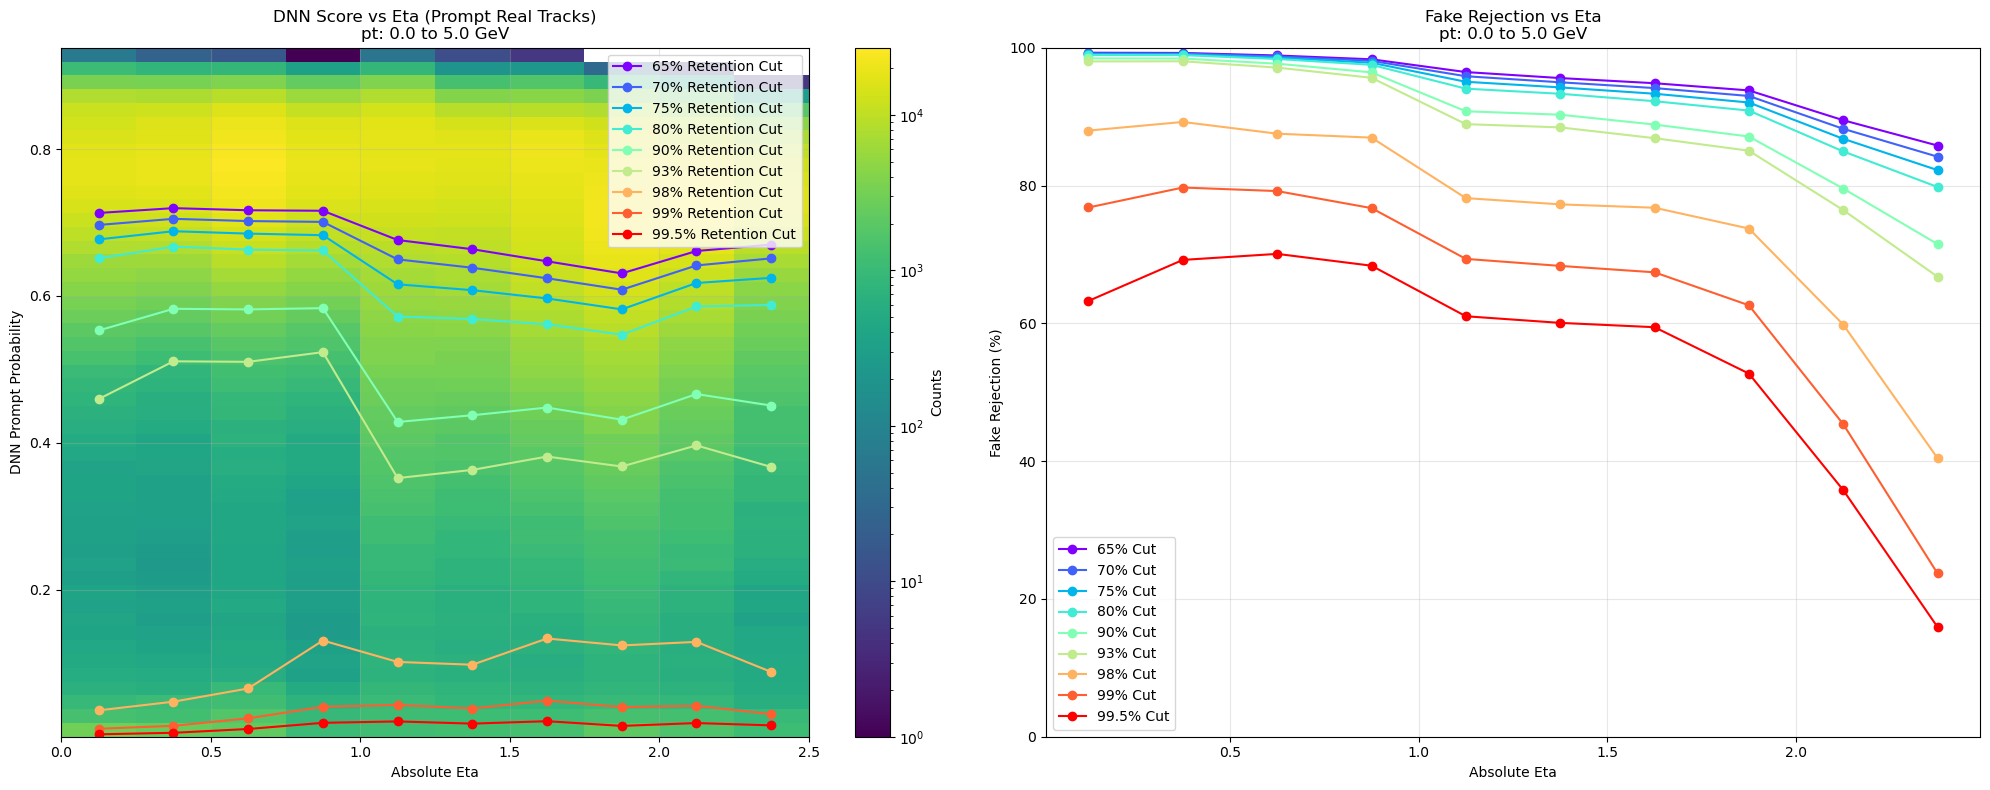


Prompt tracks, pt: 0.0 to 5.0 GeV
Number of true prompt tracks: 2562534
Number of fake tracks in pt bin: 8829752

65% Retention Cut Values: {0.7131, 0.7196, 0.7167, 0.7160, 0.6762, 0.6637, 0.6472, 0.6308, 0.6612, 0.6700} Mean: 0.6815000176429749
65% Cut Fake Rejections: {99.3, 99.2, 98.9, 98.3, 96.5, 95.6, 94.8, 93.8, 89.5, 85.8} Mean: 95.2%

70% Retention Cut Values: {0.6967, 0.7051, 0.7020, 0.7009, 0.6498, 0.6385, 0.6241, 0.6086, 0.6416, 0.6512} Mean: 0.6618000268936157
70% Cut Fake Rejections: {99.2, 99.2, 98.7, 98.1, 95.9, 95.0, 94.1, 93.0, 88.2, 84.2} Mean: 94.6%

75% Retention Cut Values: {0.6771, 0.6882, 0.6849, 0.6828, 0.6159, 0.6079, 0.5967, 0.5818, 0.6177, 0.6247} Mean: 0.6377999782562256
75% Cut Fake Rejections: {99.1, 99.1, 98.6, 97.8, 95.1, 94.2, 93.3, 92.0, 86.8, 82.2} Mean: 93.8%

80% Retention Cut Values: {0.6514, 0.6671, 0.6632, 0.6620, 0.5720, 0.5687, 0.5615, 0.5473, 0.5857, 0.5879} Mean: 0.6067000031471252
80% Cut Fake Rejections: {98.9, 98.9, 98.4, 97.5, 94.1, 93.3

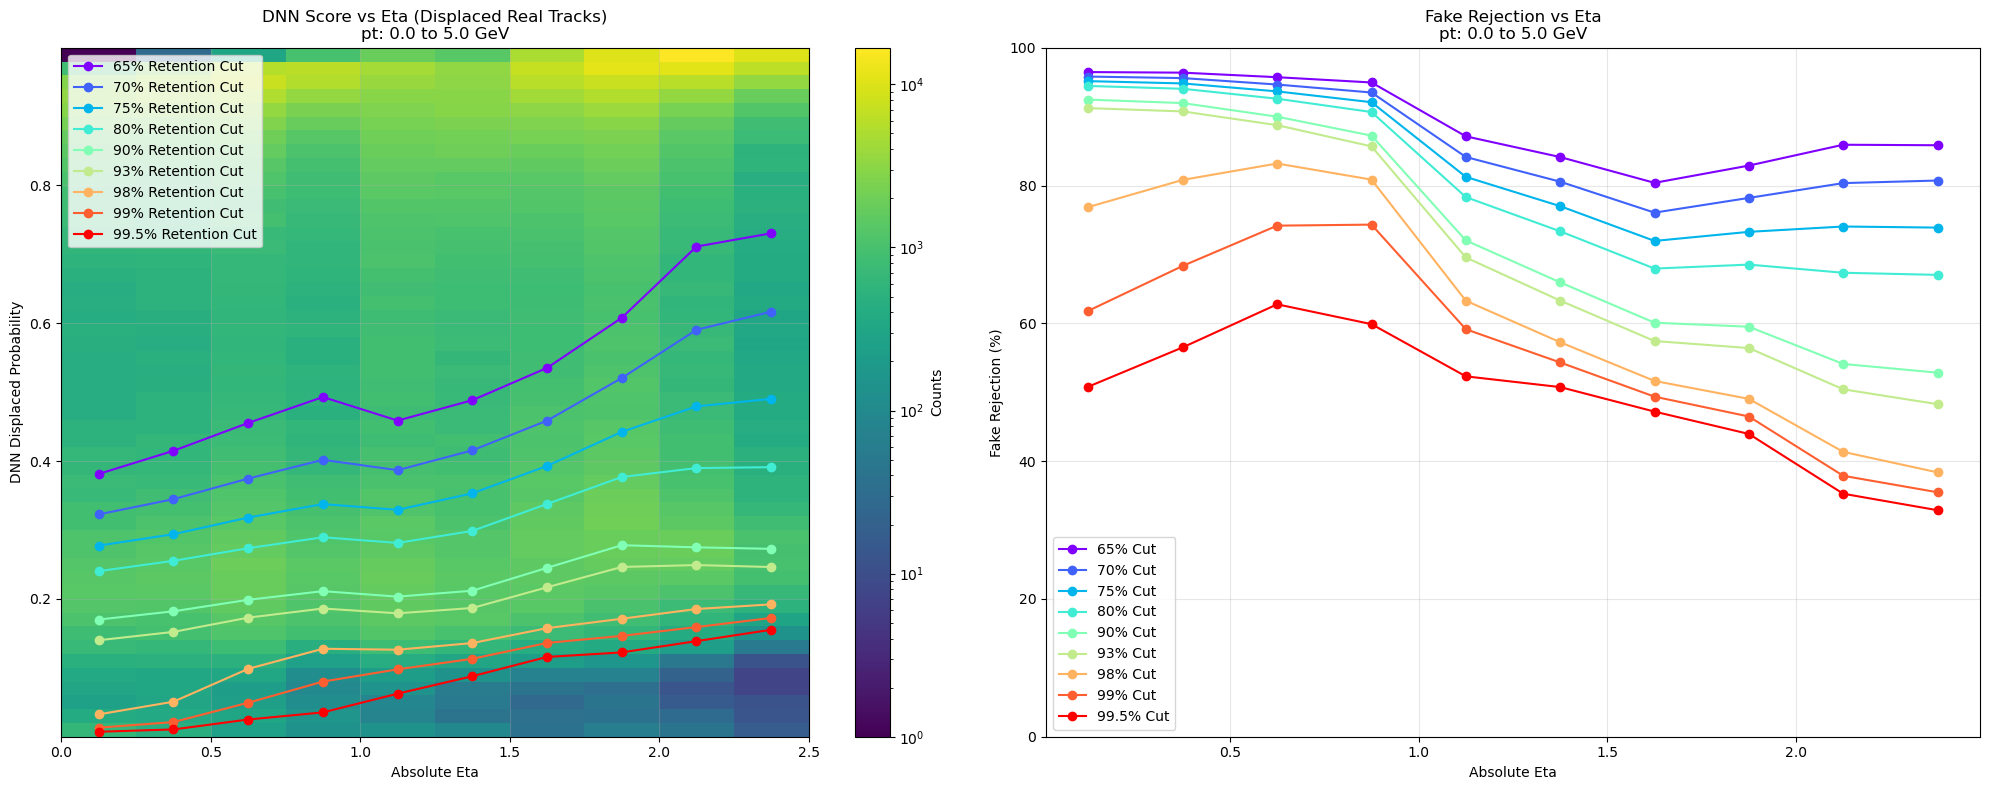


Displaced tracks, pt: 0.0 to 5.0 GeV
Number of true displaced tracks: 614435
Number of fake tracks in pt bin: 8829752

65% Retention Cut Values: {0.3813, 0.4149, 0.4553, 0.4929, 0.4587, 0.4883, 0.5352, 0.6079, 0.7113, 0.7305} Mean: 0.5275999903678894
65% Cut Fake Rejections: {96.5, 96.4, 95.7, 95.0, 87.1, 84.1, 80.4, 82.9, 85.9, 85.8} Mean: 89.0%

70% Retention Cut Values: {0.3226, 0.3448, 0.3746, 0.4018, 0.3868, 0.4155, 0.4587, 0.5205, 0.5905, 0.6168} Mean: 0.4433000087738037
70% Cut Fake Rejections: {95.8, 95.6, 94.7, 93.5, 84.1, 80.6, 76.1, 78.2, 80.4, 80.7} Mean: 86.0%

75% Retention Cut Values: {0.2773, 0.2939, 0.3180, 0.3376, 0.3293, 0.3532, 0.3929, 0.4424, 0.4794, 0.4903} Mean: 0.37139999866485596
75% Cut Fake Rejections: {95.2, 94.8, 93.7, 92.1, 81.3, 77.0, 72.0, 73.3, 74.1, 73.9} Mean: 82.7%

80% Retention Cut Values: {0.2403, 0.2553, 0.2735, 0.2894, 0.2812, 0.2987, 0.3378, 0.3769, 0.3898, 0.3912} Mean: 0.313400000333786
80% Cut Fake Rejections: {94.5, 94.0, 92.6, 90.7, 78.3,

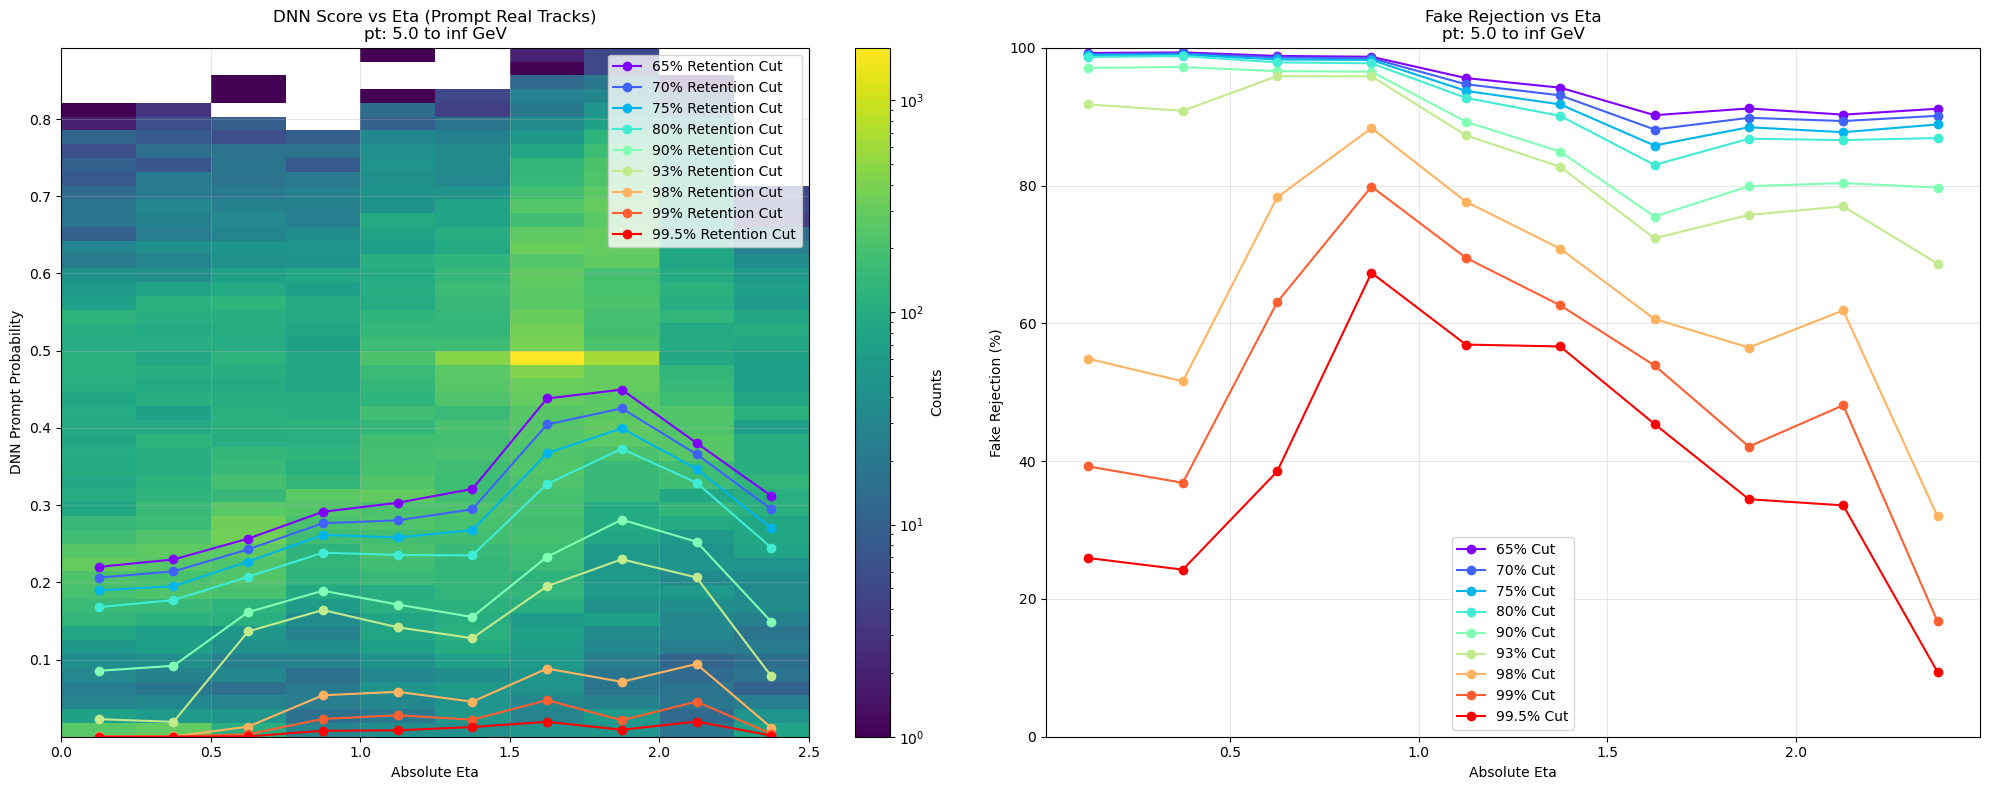


Prompt tracks, pt: 5.0 to inf GeV
Number of true prompt tracks: 51790
Number of fake tracks in pt bin: 1097302

65% Retention Cut Values: {0.2200, 0.2296, 0.2566, 0.2914, 0.3030, 0.3209, 0.4382, 0.4496, 0.3806, 0.3119} Mean: 0.32019999623298645
65% Cut Fake Rejections: {99.2, 99.3, 98.8, 98.7, 95.6, 94.2, 90.2, 91.2, 90.3, 91.1} Mean: 94.9%

70% Retention Cut Values: {0.2061, 0.2141, 0.2427, 0.2766, 0.2803, 0.2946, 0.4045, 0.4253, 0.3659, 0.2947} Mean: 0.3005000054836273
70% Cut Fake Rejections: {99.1, 99.2, 98.6, 98.5, 94.7, 93.1, 88.1, 89.8, 89.4, 90.1} Mean: 94.1%

75% Retention Cut Values: {0.1895, 0.1950, 0.2269, 0.2614, 0.2581, 0.2676, 0.3672, 0.3995, 0.3469, 0.2702} Mean: 0.2782000005245209
75% Cut Fake Rejections: {98.9, 99.0, 98.3, 98.2, 93.7, 91.8, 85.8, 88.5, 87.7, 88.9} Mean: 93.1%

80% Retention Cut Values: {0.1679, 0.1769, 0.2072, 0.2384, 0.2355, 0.2349, 0.3273, 0.3730, 0.3290, 0.2449} Mean: 0.2535000145435333
80% Cut Fake Rejections: {98.7, 98.8, 97.9, 97.7, 92.7, 90.1,

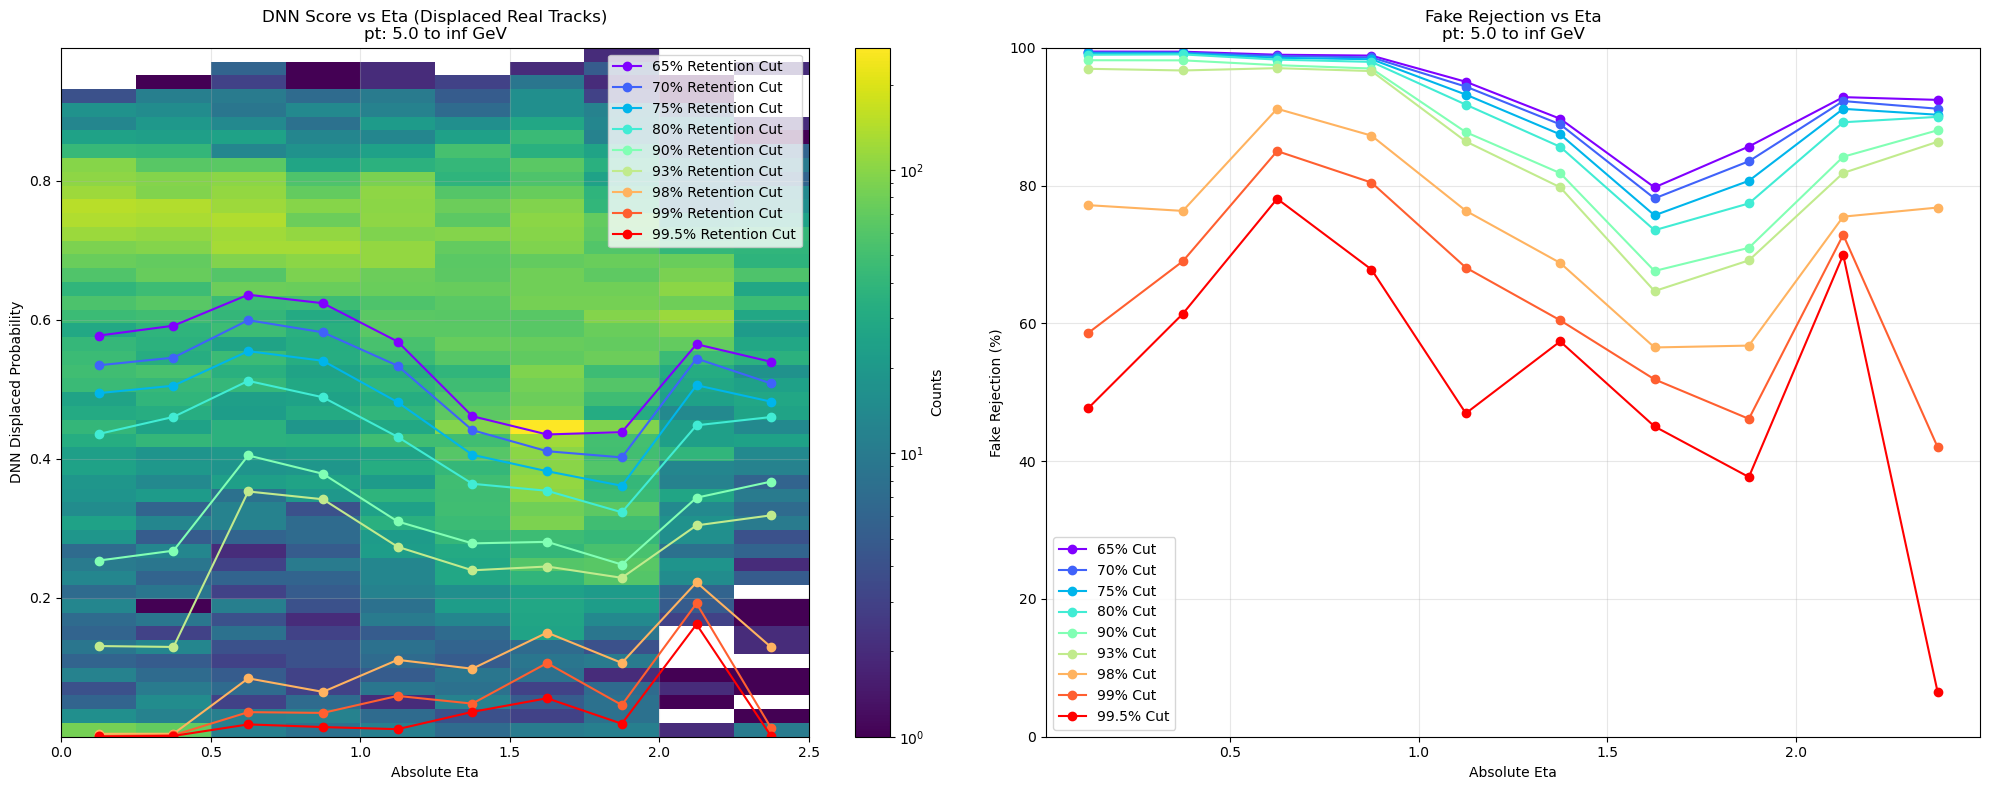


Displaced tracks, pt: 5.0 to inf GeV
Number of true displaced tracks: 17314
Number of fake tracks in pt bin: 1097302

65% Retention Cut Values: {0.5771, 0.5913, 0.6359, 0.6237, 0.5685, 0.4611, 0.4348, 0.4382, 0.5647, 0.5393} Mean: 0.5435000061988831
65% Cut Fake Rejections: {99.4, 99.4, 99.0, 98.9, 95.1, 89.7, 79.7, 85.7, 92.8, 92.4} Mean: 93.2%

70% Retention Cut Values: {0.5343, 0.5454, 0.5993, 0.5818, 0.5337, 0.4410, 0.4108, 0.4019, 0.5440, 0.5082} Mean: 0.5099999904632568
70% Cut Fake Rejections: {99.3, 99.3, 98.8, 98.6, 94.4, 88.9, 78.1, 83.5, 92.3, 91.1} Mean: 92.4%

75% Retention Cut Values: {0.4943, 0.5050, 0.5547, 0.5408, 0.4812, 0.4056, 0.3820, 0.3611, 0.5057, 0.4820} Mean: 0.47119998931884766
75% Cut Fake Rejections: {99.2, 99.2, 98.5, 98.3, 93.2, 87.4, 75.7, 80.7, 91.1, 90.3} Mean: 91.4%

80% Retention Cut Values: {0.4356, 0.4601, 0.5120, 0.4883, 0.4314, 0.3639, 0.3538, 0.3229, 0.4480, 0.4599} Mean: 0.4275999963283539
80% Cut Fake Rejections: {99.0, 99.0, 98.3, 97.9, 91.7,

In [10]:
#multi-class version
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import torch

# Ensure input_features_tensor is on the right device
input_features_tensor = input_features_tensor.to(device)

t4_pt = np.concatenate(branches['t4_pt'])

# Get model predictions
with torch.no_grad():
    model.eval()
    outputs = model(input_features_tensor)
    predictions = outputs.cpu().numpy()  # Shape will be [n_samples, 3]


def plot_for_pt_bin(pt_min, pt_max, percentiles, eta_bin_edges, t4_pt, predictions, t4_sim_vxy, eta_list):
    """
    Calculate and plot cut values for specified percentiles in a given pt bin, separately for prompt and displaced tracks
    """
    # Filter data based on pt bin
    pt_mask = (t4_pt > pt_min) & (t4_pt <= pt_max)
    
    # Get absolute eta values for all tracks in pt bin
    abs_eta = np.abs(eta_list[0][pt_mask])
    
    # Get predictions for all tracks in pt bin
    pred_filtered = predictions[pt_mask]
    
    # Get track types using pMatched and t4_sim_vxy
    matched = (np.concatenate(branches['t4_pMatched']) > 0.95)[pt_mask]
    fake_tracks = (np.concatenate(branches['t4_pMatched']) <= 0.75)[pt_mask]
    true_displaced = (t4_sim_vxy[pt_mask] > 0.1) & matched
    true_prompt = ~(t4_sim_vxy[pt_mask] > 0.1) & matched
    
    # Separate plots for prompt and displaced tracks
    for track_type, true_mask, pred_idx, title_suffix in [
        ("Prompt", true_prompt, 1, "Prompt Real Tracks"),
        ("Displaced", true_displaced, 2, "Displaced Real Tracks")
    ]:
        # Dictionaries to store values
        cut_values = {p: [] for p in percentiles}
        fake_rejections = {p: [] for p in percentiles}
        
        # Get probabilities for this class
        probs = pred_filtered[:, pred_idx]
        
        # Create two side-by-side plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Plot probability distribution (only for true tracks of this type)
        h = ax1.hist2d(abs_eta[true_mask], 
                      probs[true_mask], 
                      bins=[eta_bin_edges, 50], 
                      norm=LogNorm())
        plt.colorbar(h[3], ax=ax1, label='Counts')
        
        # For each eta bin
        bin_centers = []
        for i in range(len(eta_bin_edges) - 1):
            eta_min, eta_max = eta_bin_edges[i], eta_bin_edges[i+1]
            bin_center = (eta_min + eta_max) / 2
            bin_centers.append(bin_center)
            
            # Get tracks in this eta bin
            eta_mask = (abs_eta >= eta_min) & (abs_eta < eta_max)
            
            # True tracks of this type in this bin
            true_type_mask = eta_mask & true_mask
            # Fake tracks in this bin
            fake_mask = eta_mask & fake_tracks
            
            print(f"Eta bin {eta_min:.2f}-{eta_max:.2f}: {np.sum(fake_mask)} fakes, {np.sum(true_type_mask)} true {track_type}")
            
            if np.sum(true_type_mask) > 0:  # If we have true tracks in this bin
                for percentile in percentiles:
                    # Calculate cut value to keep desired percentage of true tracks
                    cut_value = np.percentile(probs[true_type_mask], 100 - percentile)
                    cut_values[percentile].append(cut_value)
                    
                    # Calculate fake rejection for this cut
                    if np.sum(fake_mask) > 0:
                        fake_rej = 100 * np.mean(probs[fake_mask] < cut_value)
                        fake_rejections[percentile].append(fake_rej)
                    else:
                        fake_rejections[percentile].append(np.nan)
            else:
                for percentile in percentiles:
                    cut_values[percentile].append(np.nan)
                    fake_rejections[percentile].append(np.nan)
        
        # Plot cut values and fake rejections
        colors = plt.cm.rainbow(np.linspace(0, 1, len(percentiles)))
        bin_centers = np.array(bin_centers)
        
        for (percentile, color) in zip(percentiles, colors):
            values = np.array(cut_values[percentile])
            mask = ~np.isnan(values)
            if np.any(mask):
                # Plot cut values
                ax1.plot(bin_centers[mask], values[mask], '-', color=color, marker='o',
                        label=f'{percentile}% Retention Cut')
                # Plot fake rejections
                rej_values = np.array(fake_rejections[percentile])
                ax2.plot(bin_centers[mask], rej_values[mask], '-', color=color, marker='o',
                        label=f'{percentile}% Cut')
        
        # Set plot labels and titles
        ax1.set_xlabel("Absolute Eta")
        ax1.set_ylabel(f"DNN {track_type} Probability")
        ax1.set_title(f"DNN Score vs Eta ({title_suffix})\npt: {pt_min:.1f} to {pt_max:.1f} GeV")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.set_xlabel("Absolute Eta")
        ax2.set_ylabel("Fake Rejection (%)")
        ax2.set_title(f"Fake Rejection vs Eta\npt: {pt_min:.1f} to {pt_max:.1f} GeV")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 100)
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"\n{track_type} tracks, pt: {pt_min:.1f} to {pt_max:.1f} GeV")
        print(f"Number of true {track_type.lower()} tracks: {np.sum(true_mask)}")
        print(f"Number of fake tracks in pt bin: {np.sum(fake_tracks)}")
        
        for percentile in percentiles:
            print(f"\n{percentile}% Retention Cut Values:",
                  '{' + ', '.join(f"{x:.4f}" if not np.isnan(x) else 'nan' for x in cut_values[percentile]) + '}',
                  f"Mean: {np.round(np.nanmean(cut_values[percentile]), 4)}")
            print(f"{percentile}% Cut Fake Rejections:",
                  '{' + ', '.join(f"{x:.1f}" if not np.isnan(x) else 'nan' for x in fake_rejections[percentile]) + '}',
                  f"Mean: {np.round(np.nanmean(fake_rejections[percentile]), 1)}%")

def analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, t4_pt, predictions, t4_sim_vxy, eta_list):
    """
    Analyze and plot for multiple pt bins and percentiles
    """
    for i in range(len(pt_bins) - 1):
        plot_for_pt_bin(pt_bins[i], pt_bins[i + 1], percentiles, eta_bin_edges,
                       t4_pt, predictions, t4_sim_vxy, eta_list)

# Run the analysis with same parameters as before
percentiles = [65, 70, 75, 80, 90, 93, 98, 99, 99.5]
pt_bins = [0, 5, np.inf]
eta_bin_edges = np.arange(0, 2.75, 0.25)

analyze_pt_bins(
    pt_bins=pt_bins,
    percentiles=percentiles,
    eta_bin_edges=eta_bin_edges,
    t4_pt=t4_pt,
    predictions=predictions,
    t4_sim_vxy=np.concatenate(branches['t4_sim_vxy']),
    eta_list=eta_list
)